## Noise Floor calculations
- LSB is the smallest resolvable voltage resolution of the ADC, also acts as a "Maximum noise floor" $V_{lsb} = \frac{V_{ref}}{2^N}$
- As V_ref is increased, Resolution decreases but noise floor can be neglected
  https://www.ti.com/lit/an/sloa150a/sloa150a.pdf
- move noise calculations down under filter
  https://www.analog.com/en/resources/analog-dialogue/articles/rules-for-high-speed-differential-adc-drivers.html
- https://www.analog.com/en/resources/analog-dialogue/articles/practical-filter-design-precision-adcs.html

In [27]:
# Imports and Variable definitions
# dont forget to do $source .venv/bin/activate and install any packeges you need. dont forget to also "deactivate"
import numpy as np
## TODO: add Noise floor calcs onto the external addition, w/ shot and 1/f

V_ref_proposed = 1.1    # Proposed V_ref (50 mV)

peak = 3 # input peak (rms was too hard to find haha)
Noise_sys = 0.008  # System noise RMS (V)
SINAD_adc = 72.6 # dB
ADC_bits = 10 # ADC bits

user_V_ref = 6

In [28]:
V_ref = peak * 1.1 #10% drift
quant_noise = V_ref / (2**ADC_bits * np.sqrt(12))
noise_total = np.sqrt(Noise_sys**2 + quant_noise**2)

SNR_sys = 20 * np.log10(peak / noise_total)

SINAD_total = -10 * np.log10(10**(-SINAD_adc/10) + 10**(-SNR_sys/10))
ENOB = (SINAD_total - 1.76) / 6.02

print(f"Optimal V_ref: {V_ref:.3f} V")
print(f"Quantization Noise: {quant_noise:.6f} V RMS")
print(f"Total Noise: {noise_total:.6f} V RMS")
print(f"System SNR: {SNR_sys:.2f} dB")
print(f"Total SINAD: {SINAD_total:.2f} dB")
print(f"ENOB: {ENOB:.2f} bits")

Optimal V_ref: 3.300 V
Quantization Noise: 0.000930 V RMS
Total Noise: 0.008054 V RMS
System SNR: 51.42 dB
Total SINAD: 51.39 dB
ENOB: 8.24 bits


links 
[noise from TI](https://www.ti.com/lit/an/slva043b/slva043b.pdf)

# Alias Filter & Acq Time design

In [29]:
## ADC121C021CIMM
f_c = 22e3  # 40 kHz
target_settled = 0.99
input_R = 1e3
# Define the resistor search range (in ohms)
R_min = 50   # 1 kΩ
R_max = 10e3  # 10 kΩ
num_points = 96  # Number of discrete resistor values to try

C_samp = 20e-12 # intrinic to the ADC 

In [30]:
R_values = np.linspace(R_min, R_max, num_points)

C_values = 1 / (2 * np.pi * f_c * R_values)
RC_values = R_values * C_values

t_acq = 9 * (R_values + input_R)*C_samp
settle_values = 1 - np.exp(-t_acq / RC_values)

errors = np.abs(settle_values - target_settled)

best_index = np.argmin(errors)

best_R = R_values[best_index]
best_C = C_values[best_index]
best_RC = RC_values[best_index]
best_settle = settle_values[best_index]
best_error = errors[best_index]

print("Optimized RC Filter Parameters:")
print(f"Resistor (R): {best_R:.2f} Ω")
print(f"Capacitor (C): {best_C*1e9:.2f} nF")
print(f"RC Time Constant: {best_RC*1e6:.2f} us")
print(f"(best) t_acq: {t_acq[best_index]*1e6:.4f} us")
print(f"Settling at t_acq: {best_settle*100:.2f}%")
print(f"Error from target settling: {best_error*100:.2f}%")
# (This formula ensures system noise doesn't degrade ADC performance)

Optimized RC Filter Parameters:
Resistor (R): 10000.00 Ω
Capacitor (C): 0.72 nF
RC Time Constant: 7.23 us
(best) t_acq: 1.9800 us
Settling at t_acq: 23.94%
Error from target settling: 75.06%


## MFB Filters (LP)

**Auto generator!**
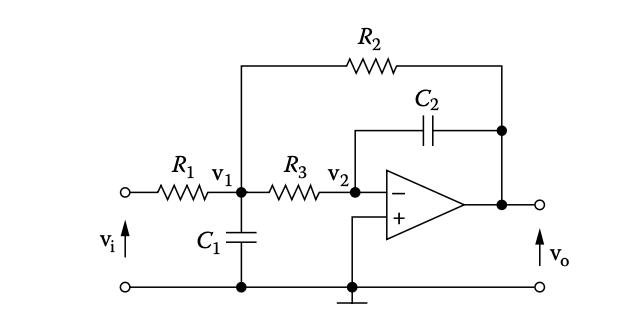

In [31]:
# Butterworth
# gain should be (V_ref-15%) / (V_in max) 
K = 3/(peak*1.1) # Gain V/V
a = 1.414 # aka b0 
b = 1.000 # aka b1
f_c = 22e3


In [32]:
# normalization
R_n = 1 # normalized input resistance
ISF = 10e4 # Impedence Scale Factor
FSF = 2*np.pi*f_c #freq scale factor
C_1n = (2*K + 1) / (a*K)
C_2n = a / ((2*K + 1) * b)

# denormalization
C_1 = C_1n/(ISF * FSF)
C_2 = C_2n/(ISF * FSF) 
R = R_n * ISF
R_2 = K*R

print(f"C1 = {C_1*10e9:.2f} nF")
print(f"C2 = {C_2*10e9:.2f} nF")
print(f"R1 & R3 = {R/10e3:.2f} kOhm")
print(f"R2 = {R_2/10e3:.2f} kOhm")
R_arr = {R,R_2,R}




C1 = 1.59 nF
C2 = 0.36 nF
R1 & R3 = 10.00 kOhm
R2 = 9.09 kOhm


In [33]:
for i in range(R_arr):
    np.sqrt(kb*T*R_arr[i])

TypeError: 'set' object cannot be interpreted as an integer